# HW4: Bayesian Mixture Models


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Jake

**Names of any collaborators:** _Names here_

*Due: 11:59pm Monday, May 3, 2021 via GradeScope*

---

In this homework assignment we will investigate image segmentation ---specifically, separating the background from the foreground of the image. To do so, you'll learn Bayesian mixtures of Gaussians using Gibbs sampling.

### Background: Image Segmentation
The figure below shows the original input image and the resulting segmentations into background and foreground. By the end of this assignment, you will have implemented the algorithm to achieve this segmentation.

Reference on image segmentation: https://en.wikipedia.org/wiki/Image_segmentation

![Fox](images/fox_seg.png "Segmentation of fox image")


### Background: Non-Bayesian Mixtures

To set the stage, we begin with a straightforward finite mixture model to cluster the pixels (with the number of clusters $K = 2$ in our image segmentation problem). The likelihood of the model is defined as a mixture of Gaussian distributions.

$$
p(x_n \mid z_n, \{\mu_k, \Sigma_k\}_{k=1}^K) = \mathcal{N}(x_n; \mu_{z_n}, \Sigma_{z_n})
$$

where $x_n \in \mathbb{R}^D$ is distributed according to a Gaussian distribution with the specified mean, $\mu_k$, and covariance, $\Sigma_k$, for its correspondign cluster $z_n = k$. We will represent the images as a set of $N$ pixels, $\{x_n\}_{n=1}^N$, each in $D=3$ dimensional space, since there are three color channels (red, green, and blue).

### Bayesian Mixture

We specify the following priors on $\mu_k$, $\Sigma_k$, and $\pi$.
- Assume a normal-inverse-Wishart prior prior for each cluster mean and covariance.
\begin{align} 
p(\mu_k, \Sigma_k) &= \mathrm{IW}(\Sigma_k \mid \Psi_0, \nu_0) \, \mathcal{N}(\mu_k \mid m_0, \kappa_0^{-1} \Sigma_k)
\end{align}
Here $\Psi_0, \nu_0, m_0, \kappa_0$ are hyper-parameters.

- We give a symmetric Dirichlet distribution prior to the mixing proportions, $\pi$:
$$ 
p(\pi \mid \alpha) = \text{Dirichlet}(\alpha)
$$
with the hyper-parameter $\alpha$.

## Problem 1 [math]: posterior calculations
In this problem, you will derive the conditional posterior distributions of the various model parameters.

These are related to the joint posterior distribution:
$$
p(\pi, \{\mu_k, \Sigma_k\}_{k=1}^K, \{z_n\}_{n=1}^N \mid \{x_n\}_{n=1}^N, \alpha, \nu_0, \Psi_0, m_0, \kappa_0) 
\propto p(\pi \mid \alpha) \prod_{k=1}^K p(\mu_k, \Sigma_k \mid \nu_0, \Psi_0, m_0, \kappa_0) \prod_{n=1}^N p(z_n \mid \pi) p(x_n \mid \mu_{z_n}, \Sigma_{z_n})
$$


You will need these derivations to be correct for the implementation in Problem 2 to be correct, so we highly recommend taking the time to double check them.

### (a) Derive the complete conditional for the parameters $\mu_k, \Sigma_k$.
It should be a normal-inverse-Wishart distribution, like the prior.

The conditional distributions for $z_n$ and $\pi$ are the same as shown in lecture.

Starting from the result $p(\eta_k|-) \propto p(\eta_k|\phi, \nu) \prod_{n:z_n = k}p(x_n|\eta_k)$ proven in lecture, we can write,  
\begin{gather}
p(\mu_k, \Sigma_k | \mathcal D) = p(\mu_k, \Sigma_k|\pi, \{z_n\}_{n=1}^N, \{x_n\}_{n=1}^N, \alpha, \nu_0, \Psi_0, m_0, \kappa_0) \propto p(\mu_k, \Sigma_k|m_0, \kappa_0, \Psi_0, \nu_0) \prod_{n:z_n = k}p(x_n|\mu_k, \Sigma_k) \\
= NIW(\mu_k, \Sigma_k | m_0, \kappa_0, \Psi_0, \nu_0) * \prod_{n:z_n = k} \mathcal N(x_n|\mu_k, \Sigma_k)\\
\prod_{n:z_n = k} \mathcal N(x_n|\mu_k, \Sigma_k) \propto |\Sigma_k|^{-n/2}\exp(-\frac{1}{2}\sum_{n:z_n = k}(x_n - \mu_k)^T\Sigma_k^{-1}(x_n - \mu_k)) \\
= |\Sigma_k|^{-n/2}\exp(-\frac{1}{2}\mathrm{tr}(\Sigma_k^{-1}\sum_{n:z_n = k}(x_n - \mu_k)(x_n - \mu_k)^T))
\end{gather}

And now using the definition of $NIW(\mu_k, \Sigma_k | m_0, \kappa_0, \Psi_0, \nu_0)$ from wikipedia, we have,  
\begin{gather}
p(\mu_k, \Sigma_k | \mathcal D) \propto NIW(\mu_k, \Sigma_k | m_0, \kappa_0, \Psi_0, \nu_0) * \prod_{n:z_n = k} \mathcal N(x_n|\mu_k, \Sigma_k) \\
\propto  |\Sigma_k|^{-n/2}\exp(-\frac{1}{2}\mathrm{tr}(\Sigma_k^{-1}\sum_{n:z_n = k}(x_n - \mu_k)(x_n - \mu_k)^T))\\
 * |\Sigma_k|^{-(\nu_0 + D - 2)/ 2}\exp(\frac{-1}{2}\mathrm{tr}(\Psi_0 \Sigma_k^{-1}) - \frac{-\kappa_0}{2}(\mu_k - m_0)^T\Sigma_k^{-1}(\mu_k - m_0))
\end{gather}

Which is conjugate and using page 73 of BDA we get a $NIW(\mu_k, \Sigma_k | m_n, \kappa_n, \Psi_n, \nu_n)$ with parameters:
\begin{gather}
m_n = \frac{\kappa_0}{\kappa_0 + n}m_0 + \frac{n}{\kappa_0 + n}\bar x\\
\kappa_n = \kappa_0 + n \\
\nu_n = \nu_0 + n \\
\Psi_n = \Psi_0 + \sum_{n:z_n = k}(x_n - \bar x)(x_n - \bar x)^T + \frac{\kappa_0n}{\kappa_0 + n}(\bar x - m_0)(\bar x - m_0)^T
\end{gather}
Where $n = \sum_{n=1}^N \mathbb I\{z_n = k\}$.

Using the equations from lecture slides for the other parameters, we can write the complete conditional as: 
\begin{gather*}
p(\pi | \mathcal D) \propto Dir(\pi | \alpha_1 + N_1,..., \alpha_K + N_K)\\
p(\mu_k, \Sigma_k | \mathcal D) \propto NIW(\mu_k, \Sigma_k | m_n, \kappa_n, \Psi_n, \nu_n)\\
p(z_n = k|\mathcal D) = \frac{\pi_k \mathcal N(x_n | \mu_{z_n}, \Sigma_{z_n})}{\sum_K \pi_j \mathcal N(x_n | \mu_{z_n}, \Sigma_{z_n})} \\
\end{gather*}

## Problem 2: Gibbs Sampler
We have provided starter code below.
- First, you need to fill it with your own implementation of the Gibbs sampling algorithm. You may not rely on external implementations such as those offered by Tensorflow or scikit-learn.
- Then, you will test your code on a simple example.

### (a) Implement the Gibbs Sampler 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from collections import Counter

In [2]:
def gibbs(X,
          K=2, 
          n_iter=100, 
          alpha=np.ones(2), 
          m0=np.zeros(3), 
          kappa0=1.0, 
          nu0=5.0, 
          Psi0=np.eye(3)):
    """
    Run the Gibbs sampler for a mixture of Gaussians with a NIW prior.

    Input:
    - X: Matrix of size (N, D). Each row of X stores one data point
    - K: the desired number of clusters in the model. Default: 2
    - n_iter: number of iterations of Gibbs sampling. Default: 100
    - alpha: hyperparameter of the Dirichlet prior on \pi.
    - m0, kappa0, nu0, Psi0, hyperparameters of normal-inverse-Wishart prior.

    Returns: 
    - log joint probability for each iteration
    - samples of parameters and assignments over iterations

    You will use these values later on for convergence diagnostics.
    """
    N, D = X.shape
    clusters = range(K)
    
    # init random assignments
    z = np.random.randint(low=0, high=K, size=N)

    # init params
    kappa = dict.fromkeys(clusters, kappa0)
    nu = dict.fromkeys(clusters, nu0)
    Psi = dict.fromkeys(clusters, Psi0)
    m = dict.fromkeys(clusters, m0)
    alpha = np.ones(K)
    
    # init caches
    kappa_cache = []
    nu_cache = []
    Psi_cache = []
    m_cache = []
    alpha_cache = []
    z_cache = []
    n_k_cache = []
    Sigma_cache = []
    pi_cache = []
    mu_cache = []
    ll_cache = []
    
    # Define helper function for vectorized ops
    def random_indexes(prob_matrix, items):
        s = prob_matrix.cumsum(axis=0)
        r = np.random.rand(prob_matrix.shape[1])
        k = (s < r).sum(axis=0)
        return items[k]
    
    for iteration in range(n_iter):
        # Get counts of z's
        counts = dict(Counter(z))
        N_k = dict.fromkeys(clusters, 0)
        N_k.update(counts)
        n_k = np.array([i[1] for i in sorted(N_k.items(), key = lambda kv:kv[0])])
        #print(f'label counts for iteration {iteration}: {n_k}')
        
        ll = 0
        Sigma = {}
        mu = {}
        
        # sample pi
        pi = ss.dirichlet.rvs(alpha + n_k)
        ll += ss.dirichlet.logpdf(pi, alpha).sum()
        
        # update mu_k, Psi_k
        for item in N_k.items():
            k, n = item
            
            if n == 0:
                Sigma[k] = ss.invwishart.rvs(df=nu[k], scale=Psi[k])
                mu[k] = ss.multivariate_normal.rvs(mean=m[k], cov=Sigma[k] / kappa[k])
                continue
            
            # select observations
            ind = z == k
            x = X[ind,]

            # update easy ones
            kappa[k] = kappa0 + n
            nu[k] = nu0 + n
            
            # helper computations
            xbar = np.mean(x, axis=0)
            S = (x - xbar).T.dot(x - xbar) # scatter matrix
            
            # mean scatter matrix            
            Sbar = ((kappa0 * n)/(kappa0 + n)) * \
                (xbar - m0)[np.newaxis,...].T \
                    .dot((xbar - m0)[np.newaxis,...])
                    
            # update eta params
            Psi[k] = Psi0 + S + Sbar
            m[k] = (kappa0 * m0 + n * xbar) / (kappa0 + n)
            
            Sigma[k] = ss.invwishart.rvs(df=nu[k], scale=Psi[k])
            mu[k] = ss.multivariate_normal.rvs(mean=m[k],
                                               cov=Sigma[k] / kappa[k])
            
            ll += ss.invwishart.logpdf(Sigma[k], df=nu0, scale=Psi0)
            ll += ss.multivariate_normal.logpdf(mu[k], mean=m0,
                                                cov=Sigma[k] / kappa0)
            
            ll += ss.multivariate_normal.logpdf(x, mu[k], Sigma[k]).sum()
            

        # sample z
        p_x = np.array([ss.multivariate_normal.pdf(X, mu[i], Sigma[i]) for i in clusters])
        p_z = (pi.T * p_x) / np.sum(pi.T * p_x, axis=0)
        z = random_indexes(p_z, np.array(clusters))        
        ll += ss.bernoulli.logpmf(z, pi[0, 1]).sum()
        
        if iteration == n_iter - 1:
            pass
            #breakpoint()
                            
        # collect artifacts
        mu_cache.append(mu)
        Sigma_cache.append(Sigma)
        pi_cache.append(pi)
        n_k_cache.append(n_k)
        z_cache.append(z)
        kappa_cache.append(kappa)
        nu_cache.append(nu)
        Psi_cache.append(Psi)
        m_cache.append(m)
        alpha_cache.append(alpha)
        ll_cache.append(ll)
        
    return {
        'z':z_cache,
        'kappa':kappa_cache,
        'nu':nu_cache,
        'Psi':Psi_cache,
        'm':m_cache,
        'alpha':alpha_cache,
        'n_k':n_k_cache,
        'mu':np.array([list(i.values()) for i in mu_cache]),
        'Sigma':np.array([list(i.values()) for i in Sigma_cache]),
        'pi':pi_cache,
        'll':ll_cache
    }

### (b) test your implementation 
Test your example on a synthetic data set.

For example, the ground truth could be two clusters, with means [5,5,5] and [8,8,8] respectively. You could generate $50$ points in each cluster. 

Whichever example you choose, be sure to specify it and show that your implementation roughly recovers the ground truth by displaying the cluster means/covariances and trace plots of the log joint probability.

In [3]:
# Generate two clusters at specified values
cluster1, cluster2 = 5, 10
X = np.vstack([
    ss.multivariate_normal.rvs(mean = [cluster1]* 3, cov = np.eye(3), size = 50),
    ss.multivariate_normal.rvs(mean = [cluster2]* 3, cov = np.eye(3), size = 50)
    ])

In [4]:
res = gibbs(X, n_iter=100)

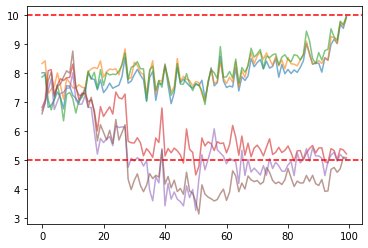

In [5]:
for i in range(2):
    for j in range(3):
        plt.plot(np.array(res['mu'])[:, i, j], alpha = 0.6)
plt.axhline(cluster1, linestyle='--', color='r')
plt.axhline(cluster2, linestyle='--', color='r')
plt.show()

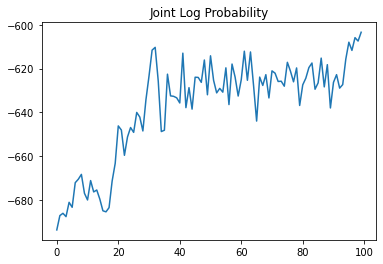

In [6]:
plt.plot(res['ll'])
plt.title('Joint Log Probability')
plt.show()

In [7]:
# print last Sigma sample
print(res['Sigma'][-1])

[[[2.97482169 2.28641204 2.76142142]
  [2.28641204 3.0741234  2.90044654]
  [2.76142142 2.90044654 4.1373364 ]]

 [[1.18444344 0.43717569 0.56972209]
  [0.43717569 1.31098843 0.26991607]
  [0.56972209 0.26991607 1.48413938]]]


## Problem 3 : Perform image segmentation
Now that you have implemented the Gibbs Sampler, you are ready to perform image segmentation!
First, we define helper code to load the images and save the segmentation.

In [8]:
def load_image(filename):
    # Read in the image, dropping the alpha channel
    image = plt.imread(filename + ".png")[:, :, :3]
    #plt.imshow(image)

    # get height, width and number of channels
    H, W, C = image.shape
    X = image.copy().astype(float)

    # reshape into pixels, each has 3 channels (RGB)
    X = X.reshape((H * W, C)) 
    return image, X

def save_segmentation(image, assignments, filename=None):
    K=2
    fig, axs = plt.subplots(1, K + 1, figsize=(4 * (K + 1), 4))
    axs[0].imshow(image)
    axs[0].set_axis_off()
    axs[0].set_title("original image")
    
    S = len(np.array(assignments))
    labels = (np.array(assignments).sum(axis=0) > S/2).astype(np.bool)
    im = image * labels.reshape(image.shape[0:2])[..., np.newaxis]
    axs[1].imshow(im)
    axs[1].set_axis_off()
    axs[1].set_title("component {}".format(0))
    
    im = image * ~labels.reshape(image.shape[0:2])[..., np.newaxis]
    axs[2].imshow(im)
    axs[2].set_axis_off()
    axs[2].set_title("component {}".format(1))
    
    plt.show()
    if filename is not None:
        plt.savefig(filename)

#### Run the Gibbs sampler
Run the Gibbs sampler on the 4 provided images: "cow", "fox", "owl", "zebra". The hyper-parameters values should be the default ones from the Gibbs function.

Each sample of $\{z_n\}_{n=1}^N$ is a segmentation. To aggregate them into one sample, you could assign each pixel to the component it was most often attributed to in your samples.

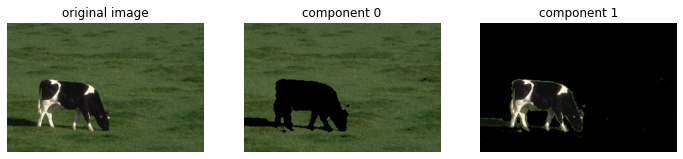

<Figure size 432x288 with 0 Axes>

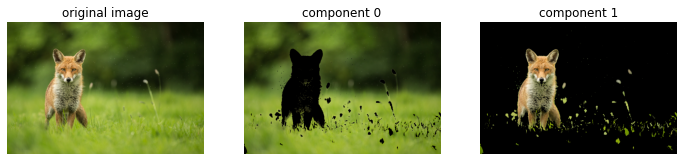

<Figure size 432x288 with 0 Axes>

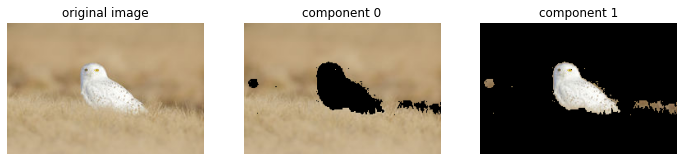

<Figure size 432x288 with 0 Axes>

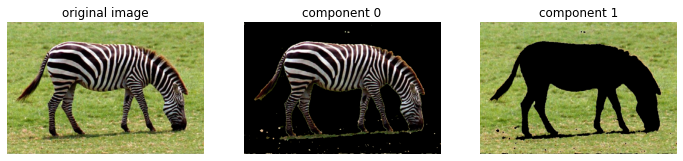

<Figure size 432x288 with 0 Axes>

In [9]:
import os
dir = './images'
cache = {}
for animal in ['cow', 'fox', 'owl', 'zebra']:
    image, X = load_image(os.path.join(dir, animal))
    res = gibbs(X, n_iter=150)
    cache[animal] = res
    cache[animal]['shape'] = X.shape
    cache[animal]['im_shape'] = image.shape
    S = len(np.array(res['z']))
    cache[animal]['labels'] = (np.array(res['z']).sum(axis=0) > S/2).astype(np.bool)
    save_segmentation(image, res['z'], f'{dir}/{animal}_segmentation.png')

## Problem 4: Diagnostics
### (a)
Make trace plots of the log joint probability and posterior marginals of the cluster means (e.g. as histograms for R, G, and B weights.)

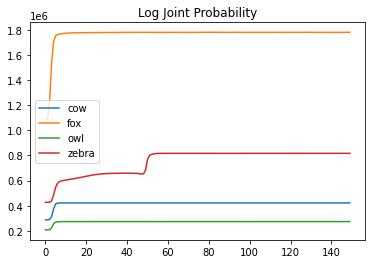

In [10]:
for item in cache.items():
    animal, res = item
    plt.plot(res['ll'], label=animal)
plt.legend()
plt.title('Log Joint Probability')
plt.show()

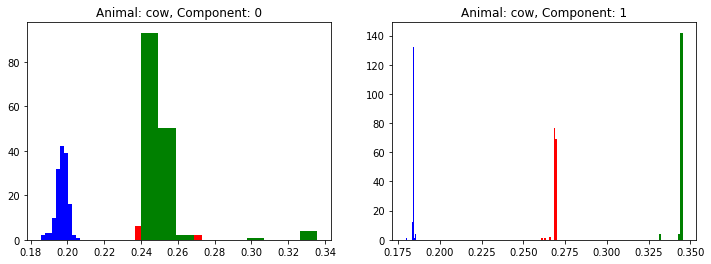

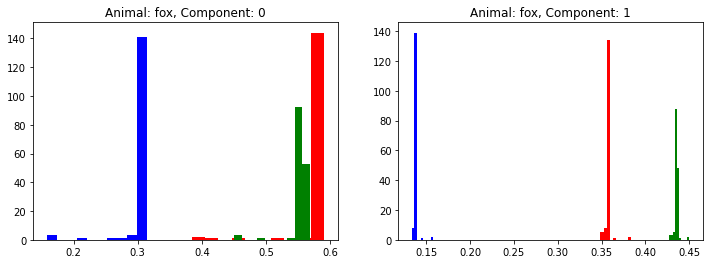

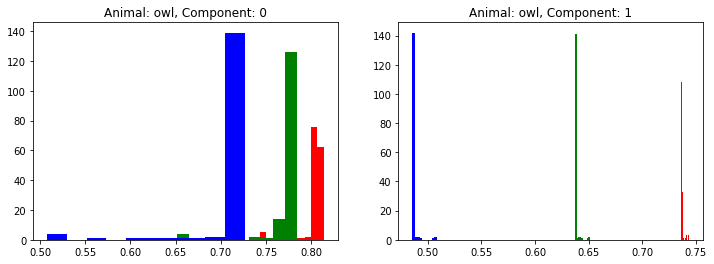

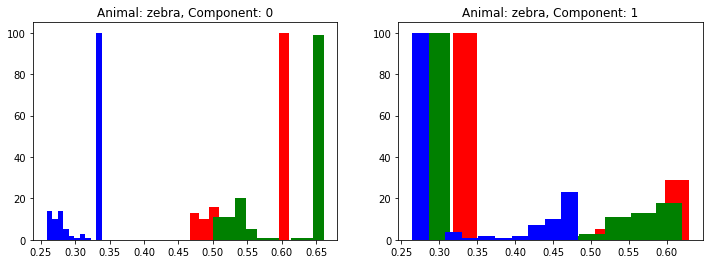

In [11]:
colors = {0: 'red', 1: 'green', 2: 'blue'}
for animal in ['cow', 'fox', 'owl', 'zebra']:
    fig, axs = plt.subplots(1, 2, figsize=(4 * (2 + 1), 4))
    for i in range(2):
        for j in range(3):
            axs[i].hist(cache[animal]['mu'][:, i, j], color = colors[j])
            axs[i].set_title(f'Animal: {animal}, Component: {i}')
    plt.show()

### (b) 
(Approximately) how many iterations are needed for convergence? Does this depend on the input image and/or initialization of the model parameters?

Convergence requires approximately 20 iterations. This does depend on the input image, especially its size (height x width) and its pixel variation within the image. The convergence also depends on parameter initialization, the priors need to be vaguelly correct for the model to gain momentum in the beginning.

## Problem 5: Extensions

### (a) Sample the posterior predictive distribution to get a new image
Plot the resulting images.  

The posterior predictive distribution is given and approximated by:
\begin{gather*}
p(\{\tilde x_n\}_{n=1}^N | \{ x_n\}_{n=1}^N) = \int p(\{\tilde x_n\}_{n=1}^N  | \pmb\theta)p(\pmb\theta|\{x_n\}_{n=1}^N)d\pmb\theta \\
\approx \frac{1}{S}\sum_{s=1}^S p(\{\tilde x_n\}_{n=1}^N  | \pmb\theta^{(s)})
\end{gather*}
Where $\pmb\theta^{(s)} \sim p(\pmb\theta | \mathcal D)$ is drawn from the posterior distribution via forward sampling from the complete conditional posterior distribution factors as derived earlier:  

\begin{gather*}
p(\pi | \mathcal D) \propto Dir(\pi | \alpha_1 + N_1,..., \alpha_K + N_K)\\
p(\mu_k, \Sigma_k | \mathcal D) \propto NIW(\mu_k, \Sigma_k | m_n, \kappa_n, \Psi_n, \nu_n)\\
p(x_n \mid \mathcal D)\propto \mathcal N(\mu_{z_n}, \Sigma_{z_n})\\
p(z_n = k|\mathcal D) = \frac{\pi_k \mathcal N(x_n | \mu_{z_n}, \Sigma_{z_n})}{\sum_K \pi_j \mathcal N(x_n | \mu_{z_n}, \Sigma_{z_n})} \\
\end{gather*}

In [16]:
def posterior_pred_dist(cache):
    shape = cache['shape']
    labels = cache['labels']
    clusters = range(2)
    res = np.zeros(shape)
    S = len(cache)
    
    for i in range(S):
        # unpack cache of gibbs samples
        kappa = cache['kappa'][i]
        alpha = cache['alpha'][i]
        Psi = cache['Psi'][i]
        mu = cache['mu'][i]
        nu = cache['nu'][i]
        n_k = cache['n_k'][i]
        m = cache['m'][i]
        z = cache['z'][i]
        

        # Compute posterior alpha
        #alpha_prime = alpha + n_k

        # Sample pi from posterior
        #pi = ss.dirichlet.rvs(alpha_prime)

        # Sample mu_k, Sigma_k from posterior
        Sigma = {
            0: ss.invwishart.rvs(df=nu[0],
                                  scale=Psi[0]),
            1: ss.invwishart.rvs(df=nu[1],
                                  scale=Psi[1])
            }
        mu = {
            0: ss.multivariate_normal.rvs(mean=m[0],
                                            cov=Sigma[0] / kappa[0]),
            1: ss.multivariate_normal.rvs(mean=m[1],
                                            cov=Sigma[1] / kappa[1])
             }
        
        # Use gibbs samples of mu and Sigma?
        '''
        mu = cache['mu'][i]
        Sigma = cache['Sigma'][i]
        '''
        
        # Sample points based off posterior parameters
        X = {
            0: ss.multivariate_normal.rvs(mean=mu[0], cov=Sigma[0], size=shape[0]),
            1: ss.multivariate_normal.rvs(mean=mu[1], cov=Sigma[1], size=shape[0])
        }

        '''
        # Compute probabilites involved in z's posterior
        p_x = np.array([ss.multivariate_normal.pdf(X[i], mu[i], Sigma[i]) for i in clusters])
        p_z = (pi.T * p_x) / np.sum(pi.T * p_x, axis=0)
        # Sample z from posterior
        z = random_indexes(p_z, np.array(clusters))
        '''
        
        # Reconstruct the result
        temp = np.zeros(shape)
        temp[z==1] = X[1][z==1]
        temp[z==0] = X[0][z==0]
        
        res += temp

    return res / S

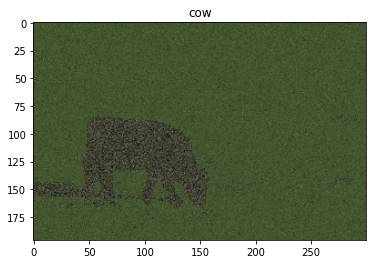

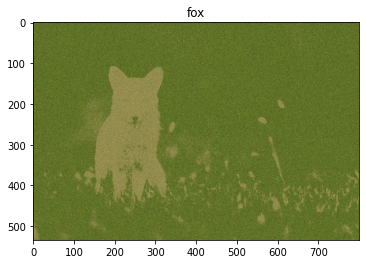

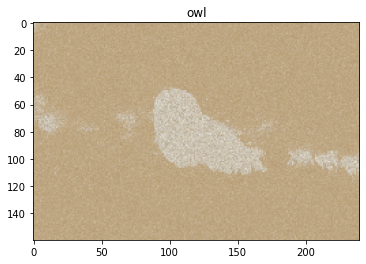

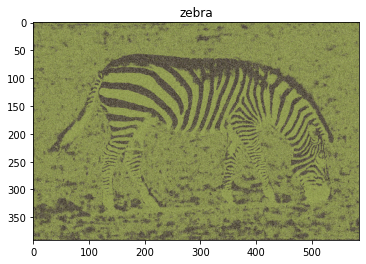

In [17]:
for animal in ['cow', 'fox', 'owl', 'zebra']:
    shape = cache[animal]['im_shape']
    sample = posterior_pred_dist(cache[animal])
    plt.title(animal)
    plt.imshow(sample.reshape(shape).clip(0,1))
    plt.show()

### (b) Improvements to the model
The generated images should not look realistic. Explain why that is the case: suggest improvements to the generative model that would make for more realistic samples.
You do not need to implement the change though.

In our posterior distribution, the model only has information about the cluster proportions ($\pi$) and the cluster parameters ($\mu_k, \Sigma_k$). When forward sampling from our model, the $z_k$ are drawn independently from $\pi$ and you lose the information of where the pixel should reside in the image. So the proportion and color will be correct, but no sequencing occurs. An  improvement would be to model the dependency between pixels so that it could account for these types of dependencies which is commonly done with undirected graphical models between pixels in an image or Convolutional Neural Networks with the convolution operator.

### (c) Label switching
What could go wrong with the proposed method of deriving segmentations in problem 3? 

If the image was particularly complex, the burn-in and convergence times will be higher. But since all assignments in each iteration have equal weight, these noisy labels will have a large affect on the segmentation masks. One way to avoid this is to weight the assignment based off its recency, such as an exponential decay that puts more weight on more recent samples.

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw4_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 